### set folder_name and day session to analyze

In [1]:
name = 'ANA1'
session = '20231211_d21'

### imports

In [2]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [3]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (143, 7)
MTXTrialType shape: (1000, 5)
number of trials: 143


In [4]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANA1/LeverData_ANA1_20231211_d21.mat' mode='r' encoding='UTF-8'>

For mac:

In [5]:
!mkdir {output_folder}

For windows:

In [6]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/: File exists


preview trials

In [7]:
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(respMTX[0:10])

[[3.020661 3.636612 1.000000 4.156997 -2.941225 0.000000 1.000000]
 [9.990730 10.755797 1.000000 13.656547 -2.941225 0.000000 1.000000]
 [18.096150 nan nan 18.823770 -2.941225 1.000000 nan]
 [21.137323 21.953046 1.000000 22.329743 -2.941225 0.000000 1.000000]
 [26.766596 27.063608 1.000000 34.995472 -2.941225 0.000000 1.000000]
 [40.871133 41.545910 1.000000 42.597663 -2.941225 0.000000 1.000000]
 [47.640200 48.298850 1.000000 49.825819 -2.941225 0.000000 1.000000]
 [56.006216 nan nan 56.301137 -2.941225 1.000000 nan]
 [58.824708 59.700173 1.000000 60.585134 -2.941225 0.000000 1.000000]
 [64.997374 65.685324 1.000000 65.708805 -2.941225 0.000000 1.000000]]


### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [18]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 30061

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 6228078
vector saved to .bin file ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/full.bin
finished a trialITI: 71065 trialITI length: 41004 samples = ~6s
vector saved to .bin file ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/trial0.bin
finished a trialITI: 118749 trialITI length: 47684 samples = ~8s
vector saved to .bin file ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/trial1.bin
finished a trialITI: 136638 trialITI length: 17889 samples = ~3s
vector saved to .bin file ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/trial2.bin
finished a trialITI: 169752 trialITI length: 33114 samples = ~5s
vector saved to .bin file ../Data_Copy/AnalysisData/ANA1/PreprocessLeverData_ANA1_20231211_d21/trial3.bin
finished a trialITI: 252718 trialITI length: 82966 

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [19]:
num_trials = 143

### Look at sampling rates for the `lever_data`

In [20]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  6.9700685
Number of leverdata samples:  41004
Estimated freq:  5882.8690134107
Trial  1
Duration in MATLAB seconds from respMTX:  8.105420100000002
Number of leverdata samples:  47684
Estimated freq:  5882.976997083716
Trial  2
Duration in MATLAB seconds from respMTX:  3.041172999999997
Number of leverdata samples:  17889
Estimated freq:  5882.269768934559
Trial  3
Duration in MATLAB seconds from respMTX:  5.6292732
Number of leverdata samples:  33114
Estimated freq:  5882.464542669558
Trial  4
Duration in MATLAB seconds from respMTX:  14.104536800000002
Number of leverdata samples:  82966
Estimated freq:  5882.22081848161
Trial  5
Duration in MATLAB seconds from respMTX:  6.769067299999996
Number of leverdata samples:  39820
Estimated freq:  5882.642059120911
Trial  6
Duration in MATLAB seconds from respMTX:  8.366015800000007
Number of leverdata samples:  49212
Estimated freq:  5882.3699567959175
Trial  7
Duration in MATLAB seconds f

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [21]:
cutoff_frequency = 40
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [22]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [23]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [24]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

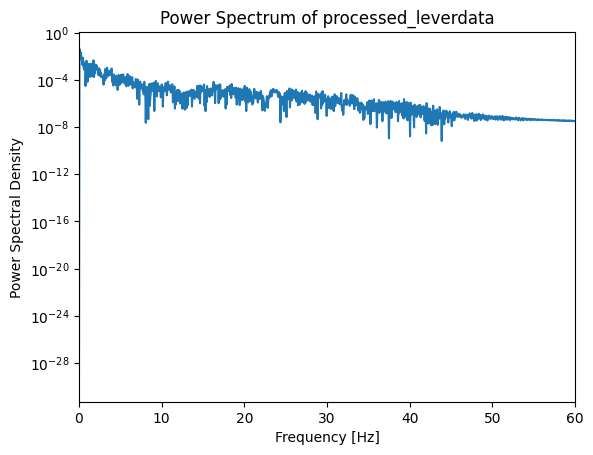

In [25]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)